rms 0.036 1/28.2
PV: lo 0.0 hi 0.178
strehl estimate 0.9502369880526824
minima [1.171 2.269 3.22 ]
peak0.975 sq: 0.952
EE 1stmin 0.791
EE 2ndmin 0.897


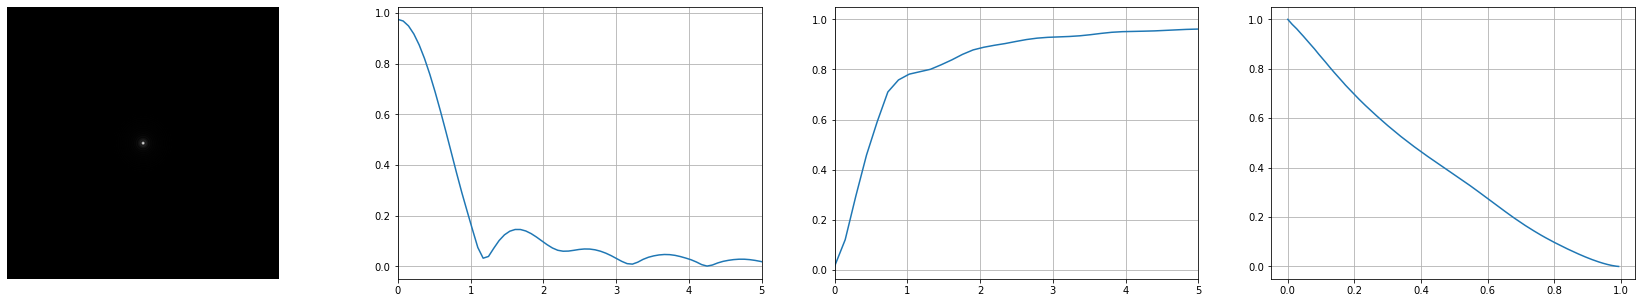

rms 0.036 1/28.2
PV: lo 0.0 hi 0.178
strehl estimate 0.9502369880526824
minima [1.171 2.269 3.22 ]
peak0.975 sq: 0.952
EE 1stmin 0.791
EE 2ndmin 0.897


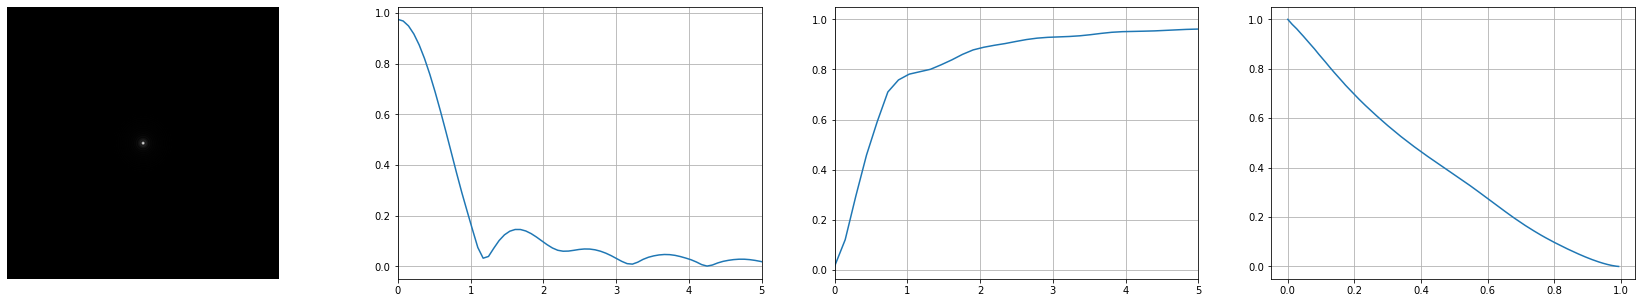

In [627]:
import numpy as np
import scipy.ndimage
from scipy.signal import argrelextrema
import matplotlib.pyplot as plt

twopi=np.pi*2

#setup calculation matrix
gridN=1024      
gridspace=1024j    
x,y=np.mgrid[-1:1:gridspace,-1:1:gridspace]
r=(x*x +y*y)

def radial_profile2(data, center):
    data=data*data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radialsum=np.cumsum(tbin) 
    radialsum=radialsum/radialsum.max()
    return radialprofile,radialsum 

def mtf(data, center):
    data=data
    y, x = np.indices((data.shape))
    r = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    r = r.astype(np.int)
    tbin = np.bincount(r.ravel(), data.ravel())
    nr = np.bincount(r.ravel())
    radialprofile = tbin / nr
    radialprofile=radialprofile/radialprofile.max()
    return radialprofile


def startest(objectief,obstruction,focus,lsa,hsa, showgraph):
    obstruct=obstruction
    
    airy1st=50*100/objectief*gridN/1024
    firstmin=3.8317/np.pi # 3.8317 is the 1st minimum of the Besselfunction J1 https://en.wikipedia.org/wiki/Airy_disk
    airy1st=airy1st/firstmin #calculate the floatingpoint position-index of the 1st minimum

    radius=objectief/(gridN*2)
    radius=radius*radius #we have squared distance to center in matrix r
    k=(r<=radius) #mask outside the radius to False 
    
    #maxintensity based on aperture and active cells in matrix 
    maxintens=k.sum()
    
    r2=r/radius #create squared radius field within radius only 
    r4=r2*r2 # and power4 radius too 
    
    #create LSA and HSA fields
    lsafield=4*(r2-r4+1/6)
    hsafield=-0.51*(20*r4*r2-30*r4+12*r2-1)
    
    #create obstruction as percentage of radius
    obstruction=objectief/(gridN*2)*obstruction/100
    l=(r>=(obstruction*obstruction)) #create mask for obstruction
    
    pupil=k*l #create pupil from aperture and obstruction
    
    #build wavefront 
    aberration=r2*focus
    
    if lsa!=0:
        aberration+= lsa*lsafield
    
    if hsa!=0:
        aberration+= hsa*hsafield
        
    aberration=twopi*aberration
    
    ficount=(k.sum()-(gridN*gridN-l.sum())) #cells in simulation
    wave=aberration*pupil #only use cells in pupil
    fisum=wave.sum()/ficount #calculate average aberration
    fisum=wave-fisum #subtract average to leave deviation
    fisum=fisum*pupil# again restrict to pupil
    fisum=np.square(fisum) #square the deviations
    rmssum=fisum.sum() #sum the deviations
    rmssum=rmssum/ficount #average
    rmssum=np.sqrt(rmssum)/twopi #square-root
    if rmssum>0:
      print(f"rms {rmssum.round(3)} 1/{(1/rmssum).round(1)}")
    else:
      print("rms=0, perfect wavefront at focus")  
    print(f"PV: lo {(wave.min()/twopi).round(3)} hi {(wave.max()/twopi).round(3)}")
    print(f"strehl estimate {(1-(twopi*rmssum)**2)}")
    
    #calculate both real and imaginary part of the wavefront
    real=np.cos(aberration)
    imag=np.sin(aberration)

    #create wavefront restricted by mask for radius and obstruction (otherwise zero)
    wavefront=(real+1j*imag)*pupil 
      
    #calculate fft on the wavefront
    dft=np.fft.fft2(wavefront)
    
    #psf=dft* np.conjugate(dft)
    #mft=abs(np.fft.fft2(psf))
    
    
    #rearrange quads from dft to form airy-disk 
    data=np.fft.fftshift(abs(dft))
    
    
    data=data/maxintens
    useMTF=True
    if useMTF:
      MTF = abs(np.fft.fftshift(np.fft.fft2(data*data)));
    
    #intensity goes down based on obstruction
#     o=obstruct/100
#     o=o*o
#     data=data*(1-o)**2
 
    if showgraph:
        num = gridN//2
        x1, y1 = 0, num # These are in _pixel_ coordinates!!
        x0, y0 = num, num
        x, y = np.linspace(x0, x1, num*2), np.linspace(y0, y1, num*2)
        # Extract the values along the line, using cubic interpolation
        zi = scipy.ndimage.map_coordinates(data, np.vstack((x,y)))
        mins=argrelextrema(zi, np.less)
        minset=mins[0]/airy1st
        
        print('minima',minset[:3].round(3))
        print(f'peak{data.max().round(3)} sq: {(data.max()**2).round(3)}')
        
        fig, ax = plt.subplots(ncols=4,figsize=(30,5))
        p,q=radial_profile2(data,[511,511])
        
        print(f'EE 1stmin {q[mins[0][0]//2].round(3)}')   
        print(f'EE 2ndmin {q[mins[0][1]//2].round(3)}')   
        x1=((x.max()-x)*2)/airy1st
        
        ax[0].imshow(data,cmap='gray')
        ax[0].axis('off')
       
        ax[1].plot(x1,zi)
        ax[1].grid(True)
        ax[1].set_xlim((0,5))
        
        x1=x1*2
        if x1.shape[0]>q.shape[0]:
           ax[2].plot(x1[:q.shape[0]],q)
        else:
           ax[2].plot(x1,q[:x1.shape[0]]) 
        ax[2].set_xlim((0,5))
        ax[2].grid(True)
        
        q=mtf(MTF,[512,512])
        x2=np.arange(0,objectief//2)
        x2=x2/(objectief/2)
        ax[3].plot(x2,q[:objectief//2])
        ax[3].grid(True)   
        plt.show()
        plt.close()
        fig.clf()
    return data

objectief=300
obstruction=0
focus=0
lsa=0.1
hsa=-0.1
data=startest(objectief,obstruction, focus,lsa,hsa,True)
data=startest(objectief,obstruction, -focus,lsa,hsa,True)

print()
